# 导入数据 包 工具

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})

In [2]:
DATA_DIR = '../data/'

# 从文件中导入数据到dataframe中
def get_df(file, header=None):
    df = pd.read_csv(file, header=None)
    # df.columns = DF_HEADER.get(key, df.columns)
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

dfjob = get_df(DATA_DIR + 'pai_job_table.csv')
dftask = get_df(DATA_DIR + 'pai_task_table.csv')
dfinstance = get_df(DATA_DIR + 'pai_instance_table.csv')
dfsensor = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfgroup = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp_spec = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm_metric = get_df(DATA_DIR + 'pai_machine_metric.csv')

### 小表jion到大表
#### dfa dataframe of tasks

In [3]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa = get_dfa(dftask, dfjob, dfinstance, dfgroup)

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


#### dfw dataframe of workers

In [4]:
def get_dfiw(dfi):
    dfiw = dfi.sort_values(['status','start_time','end_time'])
    dfiw.drop_duplicates(subset=['worker_name'], keep='last', inplace=True)
    dfiw.dropna(subset=['worker_name'], inplace=True)
    dfiw['runtime'] = dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['end_time'] \
                    - dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['start_time']
    dfiw.loc[dfiw.start_time==0, 'start_time'] = np.nan
    dfiw.loc[dfiw.start_time==0, 'end_time'] = np.nan
    return dfiw

def get_dfw(dfi, dft, dfg):
    dfw = get_dfiw(dfi)
    dfw['start_date']=dfw.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai')
    print('dfi + dft ...')
    dfw = dfw.merge(dft, on=['job_name','task_name'], how='left', suffixes=['', '_t'])
    print('dfi + dft + dfg ...')
    dfw = dfw.merge(dfg, on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfw.loc[dfw.group.isnull(),'group'] = dfw.loc[dfw.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfw

dfw = get_dfw(dfinstance, dftask, dfgroup)

dfi + dft ...
dfi + dft + dfg ...


#### dfws dataframe of worker with sensor data

In [5]:
dfws = dfw.merge(dfp_spec.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfsensor.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')


#### dfas dataframe of task with sensor data

In [6]:
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])


#### save joined table

In [ ]:
# dfa.to_csv('dfa.csv')
# dfw.to_csv('dfw.csv')
# dfws.to_csv('dfws.csv')
# dfas.to_csv('dfas.csv')

In [7]:

dfa.head(1)

,job_name,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,inst_id,user,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,600.0,29.296875,50.0,MISC,990f1799a5093b62142b101c0227875b81c7f0329301df98af1148ec8724,58540f191766,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.0,43.45,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN


In [8]:
dfa.shape

(1260920, 26)

In [9]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260920 entries, 0 to 1260919
Data columns (total 26 columns):
 #   Column         Non-Null Count    Dtype                        
---  ------         --------------    -----                        
 0   job_name       1260920 non-null  object                       
 1   task_name      1260920 non-null  object                       
 2   inst_num       1260920 non-null  float64                      
 3   status         1260920 non-null  object                       
 4   start_time     1257336 non-null  float64                      
 5   end_time       911489 non-null   float64                      
 6   plan_cpu       1242596 non-null  float64                      
 7   plan_mem       1242596 non-null  float64                      
 8   plan_gpu       1037085 non-null  float64                      
 9   gpu_type       1043312 non-null  object                       
 10  inst_id        1260920 non-null  object                       
 11

In [10]:

dfw.head(1)

,job_name,task_name,inst_name,worker_name,inst_id,status,start_time,end_time,machine,runtime,start_date,inst_num,status_t,start_time_t,end_time_t,plan_cpu,plan_mem,plan_gpu,gpu_type,user,gpu_type_spec,group,workload
0,31fe7a4e1565891f332f2b33,tensorflow,d3a2559f812a514b69832da5e024ca4a58be3acddd039c37f00bdd6ea646,7d677a8af756946d7e2d4ed024eb65475d0092361d7cb75f38f5431f4f82,4770ab9a93f5b311b629c66cfaa40ca41fb4485548b3375031d4167ed3cf,Failed,494366.0,NaN,34c2506b0fd012a7ba49cb71,NaN,1970-01-07 01:19:26+08:00,1.0,Failed,494319.0,NaN,600.0,29.296875,25.0,MISC,NaN,NaN,NaN,NaN


In [11]:

dfws.head(1)

,job_name,task_name,inst_name,worker_name,inst_id,status,start_time,end_time,machine,runtime,start_date,inst_num,status_t,start_time_t,end_time_t,plan_cpu,plan_mem,plan_gpu,gpu_type,user,gpu_type_spec,group,workload,cap_cpu,cap_mem,cap_gpu,gpu_name,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,read,write,read_count,write_count
0,337bc6f19baecbc9706b6492,worker,41e7eb6c7170b2cb514be986397729655b97dd80fd2106a0426b2071df02,998b334783ba5cfcd6f5492fecc497e4288e1aafbe07b3ab95e8481707af,cc157955ec6fe49c15ed9b033b5e1416a6d8a4315d46693be99b40ab16e3,Failed,1588823.0,NaN,fb459ec921e192e9dfc7963b,NaN,1970-01-19 17:20:23+08:00,2.0,Failed,1588821.0,NaN,600.0,29.296875,25.0,T4,38402cb323c8,NaN,e3435144ef63373c77afbfc66c44b7d9,NaN,96,512,2,/dev/nvidia0,1.620546,0.0,0.777763,0.817383,0.098633,0.098633,29754.792731,6268.233528,104.853414,63.715075


In [12]:
dfas.head(1)

,job_name,task_name,inst_num,status,start_time,end_time,gpu_type,inst_id,user,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload,cpu_usage,gpu_wrk_util,avg_mem,avg_gpu_wrk_mem,plan_cpu,plan_gpu,plan_mem,cap_cpu,cap_gpu,cap_mem
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,MISC,990f1799a5093b62142b101c0227875b81c7f0329301df98af1148ec8724,58540f191766,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.0,43.45,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN,350.353167,77.468451,24.306558,4.184025,600.0,50.0,29.296875,96,8,512


## Workload Characterization
### Overview

In [13]:
linestyle_list = [
     ('solid', 'solid'),       # Same as (0, ()) or '-'
     ('dotted', 'dotted'),     # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),     # Same as '--'
     ('dashdot', 'dashdot'),   # Same as '-.'
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('densely dashed',        (0, (5, 1))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashed',        (0, (5, 10))),
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('loosely dotted',        (0, (1, 10))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('dotted',                (0, (1, 1))),
]

def get_cdf(data, inverse=False):
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data))/(len(sorted_data)-1)
    p = 100. - p if inverse else p # CCDF
    return sorted_data, p

def plot_data_cdf(data, inverse=False, datalabel=None, xlabel=None, title=None, xlog=False, xlim=None, ylog=False, xticks=None, figsize=(4,3), dpi=120, savefig=None, ylabel=None):
    plt.figure(figsize=figsize, dpi=dpi)
    if type(data) == pd.DataFrame:
        data.dropna(inplace=True)
    x, y = get_cdf(data, inverse)
    plt.plot(x, y, label=datalabel, color='green', linestyle='-')
    if datalabel is not None: plt.legend(loc='lower right')
    if xlog: plt.xscale('log')
    if ylog: plt.yscale('log')
    if xlim is not None: plt.xlim(xlim)
    plt.ylim(0, 100)
    if xlabel is not None: plt.xlabel(xlabel)
    plt.ylabel(ylabel) if ylabel is not None else plt.ylabel('CCDF') if inverse is True else plt.ylabel('CDF')
    if title is not None: plt.title(title)
    if xticks is not None: plt.xticks(xticks)
    plt.grid(alpha=.3, linestyle='--')
    if savefig is not None:
        plt.savefig('/tmp/figures/{}.pdf'.format(savefig),bbox_inches='tight')
    else:
        plt.show()

#### 用户提交tasks数

In [14]:
user_task_count = dfa.groupby('user').count()[['job_name']]
user_task_count

,job_name
user,
0002205d68bd,36
007d78e326bc,508
009c38bf324b,4
00a00c421e54,181
00a403e2dbdf,184
...,...
fef57ebcfc9a,31
ff057ba8c65d,36
ff47c6278acc,220


<Figure size 480x360 with 0 Axes>

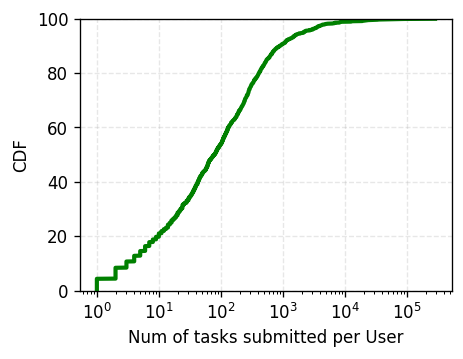

In [15]:
plt.figure(figsize=(4,3), dpi=120)
plot_data_cdf(user_task_count['job_name'], xlog=True,
              ylabel='CDF',xlabel='Num of tasks submitted per User',
              xticks=[1,10,100,10**3,10**4,10**5])

#### 每个task中的instances数

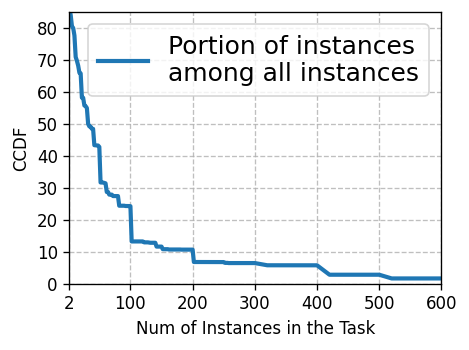

In [16]:
def get_inst_task_num_ratio(dfa, inst_num_list=[2, 8, 20, 64, 100, 256, 512]):
    total_num_task, total_num_inst = len(dfa), sum(dfa['inst_num'])
    data_df = []
    for i in inst_num_list:
        temp_df = dfa[dfa['inst_num'] >= i]
        task_num_ratio = len(temp_df) / total_num_task
        inst_num_ratio = sum(temp_df['inst_num']) / total_num_inst
        data_df.append([task_num_ratio, inst_num_ratio])
    out_df = pd.DataFrame(data_df, columns=['num_task_ratio','num_inst_ratio'])
    out_df = out_df.T.rename(columns=dict(zip(range(len(inst_num_list)), inst_num_list)))
    return out_df

inst_num_list = list(range(2, 300, 2))+list(range(300, 620, 20))
inst_task_num_ratio_df = get_inst_task_num_ratio(dfa, inst_num_list) * 100

plt.figure(figsize=(4,3), dpi=120)
plt.plot(inst_task_num_ratio_df.T.num_inst_ratio, label='Portion of instances\namong all instances')
plt.grid(alpha=0.8, linestyle='--')
plt.xlabel('Num of Instances in the Task')
plt.ylabel('CCDF')
plt.xticks((2,100,200,300,400,500,600))
plt.yticks([0,10,20,30,40,50,60,70,80])
plt.xlim(2, 600)
plt.ylim(0, 85)
plt.legend(fontsize=15)

### 时间模型
#### 一周内每个时间提交的task数量

Hour 0 Date: 1970-01-25 00:00:03+08:00


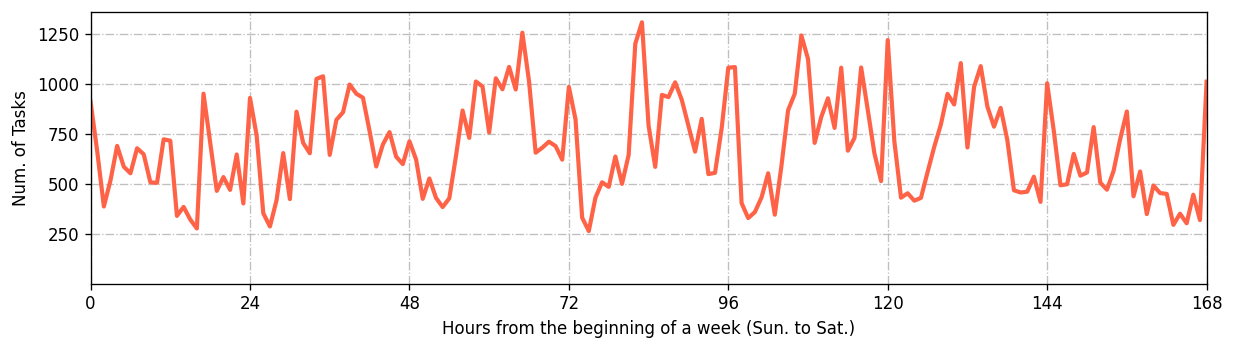

In [19]:
offset = -600
dfa['hourofyear'] = dfa.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dftcc = dfa.groupby('hourofyear').count()[['job_name']].reset_index()
dftcc['hour'] = dftcc.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=120)
num_days = 7
plt.plot(dftcc[(dftcc.hour>=0)&(dftcc.hour<24*num_days+1)].set_index('hour')[['job_name']], color='tomato')
plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
plt.ylabel('Num. of Tasks')
plt.grid(alpha=0.8, linestyle='-.')
plt.xlim(0, 24*num_days)
plt.ylim(0, )
plt.yticks([250,500,750,1000,1250])
_ = plt.xticks([24 * x for x in range(num_days+1)])

### 测试任务提交数量预测

In [109]:
dfa['minofyear'] = dfa.start_date.apply(lambda c: (c.dayofyear * 24)*60 + (c.hour)*60 + c.minute)

In [110]:
dftcc = dfa.groupby('minofyear').count()[['job_name']].reset_index()

In [112]:
dftcc.sort_values("minofyear", inplace=True)

In [113]:
dftcc.head()

,minofyear,job_name
0,10158.0,2
1,10520.0,2
2,10594.0,2
3,10782.0,2
4,10800.0,1


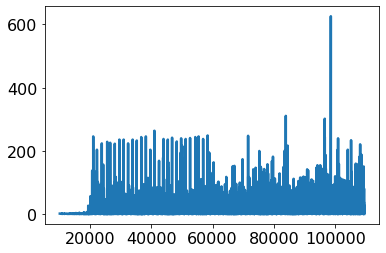

In [95]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(dftcc.minofyear, dftcc.job_name)

In [121]:
dftcc_job_of_hour = dftcc[(dftcc.minofyear>=20160)].set_index('minofyear')[['job_name']]

In [122]:
dftcc_job_of_hour.shape

(88361, 1)

In [123]:
# 将索引转换为列
dftcc_job_of_hour = dftcc_job_of_hour.reset_index()

In [130]:
dftcc_job_of_hour.head()

,minofyear,job_name,series,time_idx
0,20160.0,6,0,0
1,20161.0,7,0,1
2,20162.0,12,0,2
3,20163.0,3,0,3
4,20164.0,52,0,4


In [118]:
dftcc_job_of_hour.describe()

,minofyear,job_name
count,88471.000000,88471.000000
mean,64778.757830,14.201241
std,25806.835778,16.093432
min,20002.000000,1.000000
25%,42448.500000,6.000000
50%,64769.000000,10.000000
75%,87164.500000,17.000000
max,109438.000000,626.000000


In [41]:
int(164/24)

6

In [125]:
# 新增 series 分到每天
dftcc_job_of_hour['series'] = dftcc_job_of_hour['minofyear'].apply(
    lambda x: int(x/1440)
)

In [127]:
# 添加time_idx列
dftcc_job_of_hour['time_idx'] = dftcc_job_of_hour['minofyear'] - (dftcc_job_of_hour['series']*1440)

In [129]:
dftcc_job_of_hour['time_idx'] = dftcc_job_of_hour['time_idx'].apply(lambda x: int(x))
dftcc_job_of_hour['series'] = dftcc_job_of_hour['series'].apply(lambda x: int(x-14))

In [64]:
dftcc_job_of_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hour      168 non-null    float64
 1   job_name  168 non-null    int64  
 2   series    168 non-null    object 
 3   time_idx  168 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 5.4+ KB


In [131]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MQF2DistributionLoss, QuantileLoss

In [73]:
dftcc_job_of_hour.columns[2]

'series'

In [77]:
dftcc_job_of_hour.to_csv('test.csv')

In [132]:
dftcc_job_of_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88361 entries, 0 to 88360
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   minofyear  88361 non-null  float64
 1   job_name   88361 non-null  int64  
 2   series     88361 non-null  int64  
 3   time_idx   88361 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.7 MB


In [79]:
import pytorch_forecasting

In [135]:
dftcc_job_of_hour.head()

,minofyear,job_name,series,time_idx
0,20160.0,6,0,0
1,20161.0,7,0,1
2,20162.0,12,0,2
3,20163.0,3,0,3
4,20164.0,52,0,4


In [136]:
# 创建数据集并加载数据
max_encoder_length = 120
max_prediction_length = 30

training_cutoff = dftcc_job_of_hour["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    dftcc_job_of_hour[lambda x: x.time_idx <= training_cutoff],  # 训练集的数据需要 time_idx < training_cutoff
    time_idx="time_idx",                            # 时间索引
    target="job_name",                    # job_name 列为预测目标
    categorical_encoders={'series': NaNLabelEncoder().fit(dftcc_job_of_hour.series)},
    group_ids=["series"],
    # static_categoricals=[
    #     "series"
    # ],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["job_name"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, dftcc_job_of_hour, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

KeyError: "Unknown category '201' encountered. Set `add_nan=True` to allow unknown categories"

In [18]:
# # 依照上面将时间维度从小时转化为分钟
# offset = -600
# dfa['hourofyear'] = dfa.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
# dftcc = dfa.groupby('hourofyear').count()[['job_name']].reset_index()
# dftcc['hour'] = dftcc.hourofyear + offset
# print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

# plt.figure(figsize=(12,3), dpi=120)
# num_days = 7
# plt.plot(dftcc[(dftcc.hour>=0)&(dftcc.hour<24*num_days+1)].set_index('hour')[['job_name']], color='tomato')
# plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
# plt.ylabel('Num. of Tasks')
# plt.grid(alpha=0.8, linestyle='-.')
# plt.xlim(0, 24*num_days)
# plt.ylim(0, )
# plt.yticks([250,500,750,1000,1250])
# _ = plt.xticks([24 * x for x in range(num_days+1)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hourofyear  1595 non-null   float64
 1   job_name    1595 non-null   int64  
 2   hour        1595 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 37.5 KB


In [ ]:
dfa.head(3)

In [26]:
dftcc.describe()

,hourofyear,job_name,hour
count,1595.000000,1595.000000,1595.000000
mean,1025.156740,788.298433,425.156740
std,462.032527,579.896894,462.032527
min,169.000000,1.000000,-431.000000
25%,627.500000,494.000000,27.500000
50%,1026.000000,696.000000,426.000000
75%,1424.500000,980.000000,824.500000
max,1823.000000,7868.000000,1223.000000


Hour 0 Date: 1970-01-25 00:00:03+08:00


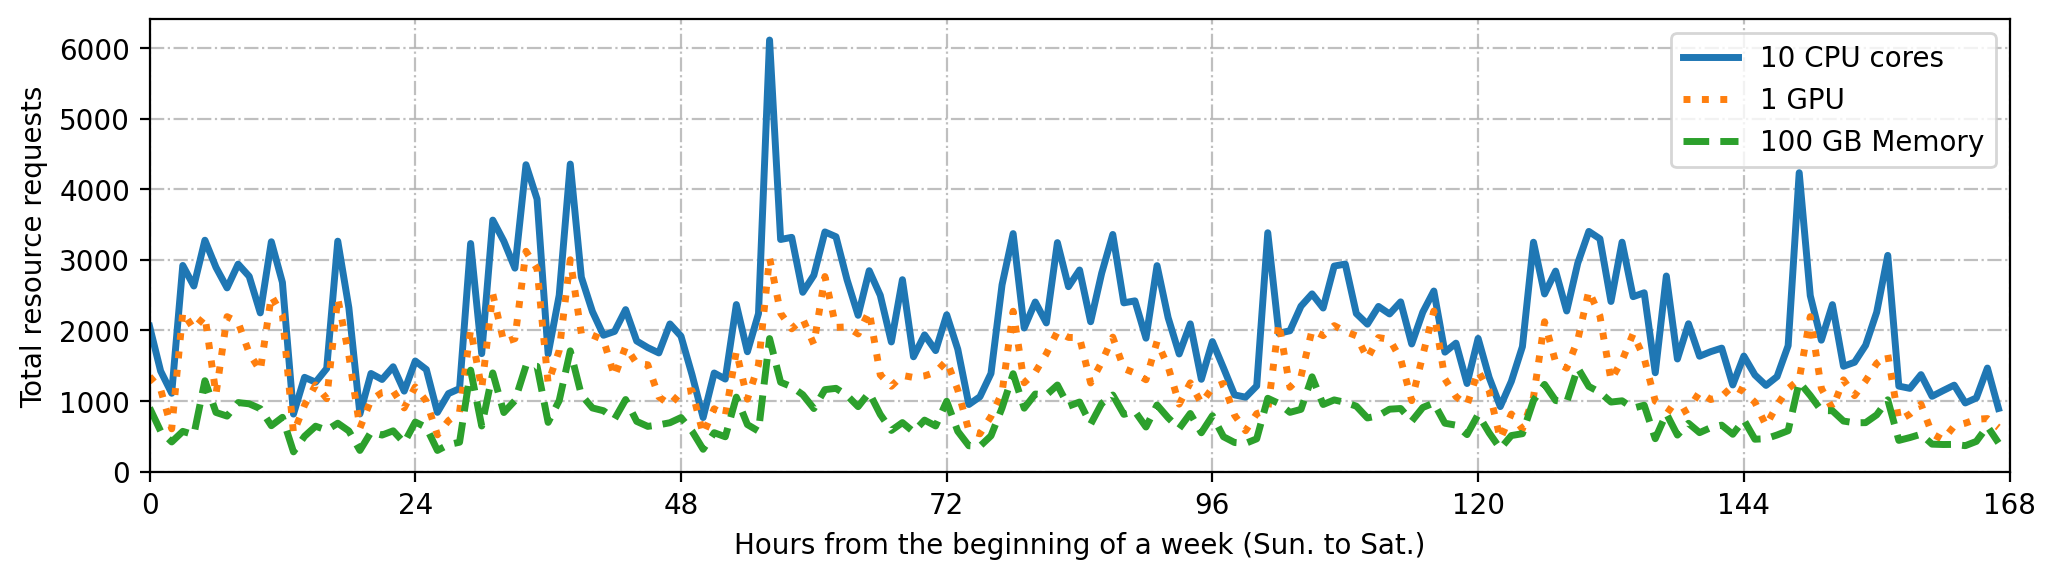

In [20]:
dfw['hourofyear'] = dfw.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dfitcr = dfw.groupby('hourofyear').sum()[['plan_cpu','plan_gpu','plan_mem']].reset_index()
dfitcr['hour'] = dfitcr.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=200)
num_days = 7
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_cpu']/1000, label='10 CPU cores', linestyle='solid')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_gpu']/100, label='1 GPU', linestyle='dotted')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_mem']/100, label='100 GB Memory', linestyle='dashed')
plt.xlabel('Hours from the beginning of a week (Sun. to Sat.)')
plt.ylabel('Total resource requests')
plt.grid(alpha=0.8, linestyle='-.')
plt.legend(ncol=1, loc='best')
plt.xlim(0, 24*num_days)
_ = plt.xticks([24 * x for x in range(num_days+1)])

In [ ]:
dfw.head()

In [21]:
dfitcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hourofyear  1578 non-null   float64
 1   plan_cpu    1578 non-null   float64
 2   plan_gpu    1578 non-null   float64
 3   plan_mem    1578 non-null   float64
 4   hour        1578 non-null   float64
dtypes: float64(5)
memory usage: 61.8 KB


In [ ]:
# 以下进行预测测试 以预测CPU为例
# 首先按照hourofyear进行排序
dfitcr.sort_values(by='hourofyear')

In [ ]:
# 转换列类型
dfitcr[["hourofyear"]] = dfitcr[["hourofyear"]].astype(int)
dfitcr["time_idx"] = [x for x in range(1578)]

# dfitcr[["time_idx"]] = dfitcr[["time_idx"]] - 169

In [ ]:
dfitcr.head()

In [ ]:
dfitcr.tail()

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MQF2DistributionLoss, QuantileLoss

In [ ]:
# 添加时间序列
dfitcr["series"]=0
# 创建数据集并加载数据
max_encoder_length = 60
max_prediction_length = 30  # 向后预测30个长度单位的数据 不一定是30个
training_cutoff = dfitcr["time_idx"].max() - max_prediction_length - 10
context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    dfitcr[lambda x: x.hourofyear <= training_cutoff],  # 训练集的数据需要 time_idx < training_cutoff
    time_idx="time_idx",                            # 时间索引
    target="plan_cpu",                                 # plan_cpu 列为预测目标
    # categorical_encoders={"series": NaNLabelEncoder().fit(dfitcr.series)},
    group_ids=["series"],     # 这里暂时指定一个不知道会不会出错
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["plan_cpu"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, dfitcr, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
# 计算baseline错误
# 这里的baseline就是要预测值的真实值
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

In [ ]:
# 训练网络
# 对于 NHITS 来说 最重要的超参数是 hidden_size
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=1.0)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
)

In [ ]:
# 寻找最优学习率
res = trainer.tuner.lr_find(
    net, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader, 
    min_lr=1e-5
    )
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion  # 为网络设置超参数

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min",
    )
trainer = pl.Trainer(
    max_epochs = 10,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)

net = NHiTS.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=128,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# 评估结果
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
dfitcr.head()